# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. We will use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, we will apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that we will use has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [55]:
# load in the data
azdias = pd.read_csv('./Data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Data/Udacity_CUSTOMERS_052018.csv', sep=';')

/tmp/ipykernel_22849/118888190.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('./Data/Udacity_AZDIAS_052018.csv', sep=';')
/tmp/ipykernel_22849/118888190.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('./Data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [56]:
# we check the categorical features for azdias and if they need to be corrected
cat_columns_azdias = azdias.select_dtypes(include='object').columns
for cat in cat_columns_azdias:
    print('for column {} there are {} unique elements'.format(cat,len(azdias.loc[:,cat].unique())))

for column CAMEO_DEU_2015 there are 46 unique elements
for column CAMEO_DEUG_2015 there are 20 unique elements
for column CAMEO_INTL_2015 there are 44 unique elements
for column D19_LETZTER_KAUF_BRANCHE there are 36 unique elements
for column EINGEFUEGT_AM there are 5163 unique elements
for column OST_WEST_KZ there are 3 unique elements


In [57]:
# we check the categorical features for customers and if they need to be corrected
cat_columns_customers = customers.select_dtypes(include='object').columns
for cat in cat_columns_customers:
    print('for column {} there are {} unique elements'.format(cat,len(customers.loc[:,cat].unique())))

for column CAMEO_DEU_2015 there are 46 unique elements
for column CAMEO_DEUG_2015 there are 20 unique elements
for column CAMEO_INTL_2015 there are 44 unique elements
for column D19_LETZTER_KAUF_BRANCHE there are 36 unique elements
for column EINGEFUEGT_AM there are 3035 unique elements
for column OST_WEST_KZ there are 3 unique elements
for column PRODUCT_GROUP there are 3 unique elements
for column CUSTOMER_GROUP there are 2 unique elements


In [65]:
# we understand that EINGEFUEGT_AM column in both datasets includes specific dates. So it should be converted to numbers
# this way we then remove this column from categorical features that can hugely reduce the number of features
# after using get_dummies() method
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])
azdias['EINGEFUEGT_AM'] = azdias.loc[~azdias['EINGEFUEGT_AM'].isnull(),'EINGEFUEGT_AM'].astype(int)

In [72]:
# do the same for customers
customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM'])
customers['EINGEFUEGT_AM'] = customers.loc[~customers['EINGEFUEGT_AM'].isnull(),'EINGEFUEGT_AM'].astype(int)

In [74]:
# now we check the categorical variables in azdias and customers
print('--------------azdias-----------')
cat_columns_azdias = azdias.select_dtypes(include='object').columns
for cat in cat_columns_azdias:
    print('for column {} there are {} unique elements'.format(cat,len(azdias.loc[:,cat].unique())))
print('--------------customers-----------')
cat_columns_customers = customers.select_dtypes(include='object').columns
for cat in cat_columns_customers:
    print('for column {} there are {} unique elements'.format(cat,len(customers.loc[:,cat].unique())))

--------------azdias-----------
for column CAMEO_DEU_2015 there are 46 unique elements
for column CAMEO_DEUG_2015 there are 20 unique elements
for column CAMEO_INTL_2015 there are 44 unique elements
for column D19_LETZTER_KAUF_BRANCHE there are 36 unique elements
for column OST_WEST_KZ there are 3 unique elements
--------------customers-----------
for column CAMEO_DEU_2015 there are 46 unique elements
for column CAMEO_DEUG_2015 there are 20 unique elements
for column CAMEO_INTL_2015 there are 44 unique elements
for column D19_LETZTER_KAUF_BRANCHE there are 36 unique elements
for column OST_WEST_KZ there are 3 unique elements
for column PRODUCT_GROUP there are 3 unique elements
for column CUSTOMER_GROUP there are 2 unique elements


In [98]:
# we see that the problem with EINGEFUEGT_AM column is solved. Now we check for further problems in categorical columns
# we see that we have problem with CAMEO_DEUG_2015 and CAMEO_INTL_2015 columns. Records are int numbers but saved as objects
# we then convert them to numbers
# we convert 'X' values to -1 as unknown
azdias.loc[azdias['CAMEO_DEUG_2015']=='X','CAMEO_DEUG_2015']=-1
# we then convert values other than nan to int values
azdias['CAMEO_DEUG_2015'] = azdias.loc[~azdias['CAMEO_DEUG_2015'].isnull(),'CAMEO_DEUG_2015'].astype(int)

In [104]:
# do the same for CAMEO_INTL_2015 column
azdias.loc[azdias['CAMEO_INTL_2015']=='XX','CAMEO_INTL_2015']=-1
azdias['CAMEO_INTL_2015'] = azdias.loc[~azdias['CAMEO_INTL_2015'].isnull(),'CAMEO_INTL_2015'].astype(int)
# do it for customers
customers.loc[customers['CAMEO_DEUG_2015']=='X','CAMEO_DEUG_2015']=-1
customers['CAMEO_DEUG_2015'] = customers.loc[~customers['CAMEO_DEUG_2015'].isnull(),'CAMEO_DEUG_2015'].astype(int)
customers.loc[customers['CAMEO_INTL_2015']=='XX','CAMEO_INTL_2015']=-1
customers['CAMEO_INTL_2015'] = customers.loc[~customers['CAMEO_INTL_2015'].isnull(),'CAMEO_INTL_2015'].astype(int)


In [105]:
# now check for categorical features
print('--------------azdias-----------')
cat_columns_azdias = azdias.select_dtypes(include='object').columns
for cat in cat_columns_azdias:
    print('for column {} there are {} unique elements'.format(cat,len(azdias.loc[:,cat].unique())))
print('--------------customers-----------')
cat_columns_customers = customers.select_dtypes(include='object').columns
for cat in cat_columns_customers:
    print('for column {} there are {} unique elements'.format(cat,len(customers.loc[:,cat].unique())))

--------------azdias-----------
for column CAMEO_DEU_2015 there are 46 unique elements
for column D19_LETZTER_KAUF_BRANCHE there are 36 unique elements
for column OST_WEST_KZ there are 3 unique elements
--------------customers-----------
for column CAMEO_DEU_2015 there are 46 unique elements
for column D19_LETZTER_KAUF_BRANCHE there are 36 unique elements
for column OST_WEST_KZ there are 3 unique elements
for column PRODUCT_GROUP there are 3 unique elements
for column CUSTOMER_GROUP there are 2 unique elements


In [106]:
# we try to wrangle azdias and prepare it to start our analysis
# calculating null percentage of each column to decide which column to be eliminated
for i in range(azdias.shape[1]):
    print('Null percentage for column {} is {:.1f}%'.format(i,(azdias.iloc[:,i].isnull().sum()/azdias.shape[0])*100))

Null percentage for column 0 is 0.0%
Null percentage for column 1 is 0.0%
Null percentage for column 2 is 8.2%
Null percentage for column 3 is 8.2%
Null percentage for column 4 is 90.9%
Null percentage for column 5 is 96.7%
Null percentage for column 6 is 99.3%
Null percentage for column 7 is 99.9%
Null percentage for column 8 is 29.5%
Null percentage for column 9 is 10.5%
Null percentage for column 10 is 10.9%
Null percentage for column 11 is 8.2%
Null percentage for column 12 is 8.2%
Null percentage for column 13 is 10.5%
Null percentage for column 14 is 8.2%
Null percentage for column 15 is 10.9%
Null percentage for column 16 is 10.5%
Null percentage for column 17 is 11.1%
Null percentage for column 18 is 11.1%
Null percentage for column 19 is 11.1%
Null percentage for column 20 is 0.5%
Null percentage for column 21 is 0.5%
Null percentage for column 22 is 0.5%
Null percentage for column 23 is 0.5%
Null percentage for column 24 is 0.5%
Null percentage for column 25 is 0.5%
Null perc

In [107]:
# We see that column 300 is relevant to cutomer status which is important for our modelling
# while 65.6% of this column is null. We then decide to change all nan values to -1 which means unknown
azdias.iloc[:,300].fillna(-1,inplace=True)

In [108]:
# column 100 is relevant to EXTSEL992 key that has no definition in the excel file with 73.4% null vlues
# we then think that this column is not important for the modelling and drop whole the column
azdias.drop(['EXTSEL992'],axis=1,inplace=True)

In [109]:
# next step is to drop all columns with more than 90 percent of null data as imputing
# would not reflect the precise action for these columns. 
for i in range(azdias.shape[1]):
    if(azdias.iloc[:,i].isnull().sum()/azdias.shape[0]*100>90):
        print('Null percentage more than 90% \
        for column {} with null percentage {:.1f}%'.\
              format(i,(azdias.iloc[:,i].isnull().sum()/\
                        azdias.shape[0])*100))

Null percentage more than 90%         for column 4 with null percentage 90.9%
Null percentage more than 90%         for column 5 with null percentage 96.7%
Null percentage more than 90%         for column 6 with null percentage 99.3%
Null percentage more than 90%         for column 7 with null percentage 99.9%


In [110]:
# we then decide to eliminate each column with more than 90% null data
dropped_cols = azdias.columns[4:8]
azdias.drop(dropped_cols,axis=1,inplace=True)

In [111]:
# check if there is one record with more than 90% null data. We proceed with dropping this record and 
# continue with imputing null records for all the columns
for i in range(azdias.shape[0]):
    if((azdias.iloc[i,:].isnull().sum()/azdias.shape[1])*100>90):
        print('Record {} has more than 90% null columns with null\
        percent {:.1f}%'.format(i,(azdias.iloc[i,:].isnull().sum()/azdias.\
                                   shape[1])*100))

In [112]:
# Result is no record having more than 90% of null data. We thus continue with imputing null records 
# for all the remaining columns. We choose mode of each column to replace null values as we are working 
# with categorical data for all the columns.
for col in azdias.columns:
    try:
        azdias[col] = azdias[col].transform(lambda x: x.fillna(x.mode()[0]))
    except:
        print('That broke...')


In [113]:
# Checking null values
for i in range(azdias.shape[1]):
    print('Null percentage for column {} is {:.1f}%'.format(i,(azdias.iloc[:,i].isnull().sum()/azdias.shape[0])*100))

Null percentage for column 0 is 0.0%
Null percentage for column 1 is 0.0%
Null percentage for column 2 is 0.0%
Null percentage for column 3 is 0.0%
Null percentage for column 4 is 0.0%
Null percentage for column 5 is 0.0%
Null percentage for column 6 is 0.0%
Null percentage for column 7 is 0.0%
Null percentage for column 8 is 0.0%
Null percentage for column 9 is 0.0%
Null percentage for column 10 is 0.0%
Null percentage for column 11 is 0.0%
Null percentage for column 12 is 0.0%
Null percentage for column 13 is 0.0%
Null percentage for column 14 is 0.0%
Null percentage for column 15 is 0.0%
Null percentage for column 16 is 0.0%
Null percentage for column 17 is 0.0%
Null percentage for column 18 is 0.0%
Null percentage for column 19 is 0.0%
Null percentage for column 20 is 0.0%
Null percentage for column 21 is 0.0%
Null percentage for column 22 is 0.0%
Null percentage for column 23 is 0.0%
Null percentage for column 24 is 0.0%
Null percentage for column 25 is 0.0%
Null percentage for co

In [114]:
# We do the same data wrangling for customers dataframe
# First we try to wrangle customers df and prepare it to start our analysis
# calculating null percentage of each column to decide which column to be eliminated
for i in range(customers.shape[1]):
    print('Null percentage for column {} is {:.1f}%'.format(i,(customers.iloc[:,i].isnull().sum()/customers.shape[0])*100))


Null percentage for column 0 is 0.0%
Null percentage for column 1 is 0.0%
Null percentage for column 2 is 24.3%
Null percentage for column 3 is 24.3%
Null percentage for column 4 is 93.9%
Null percentage for column 5 is 97.3%
Null percentage for column 6 is 99.3%
Null percentage for column 7 is 99.9%
Null percentage for column 8 is 27.1%
Null percentage for column 9 is 26.1%
Null percentage for column 10 is 27.2%
Null percentage for column 11 is 24.3%
Null percentage for column 12 is 24.3%
Null percentage for column 13 is 26.1%
Null percentage for column 14 is 24.3%
Null percentage for column 15 is 26.3%
Null percentage for column 16 is 26.1%
Null percentage for column 17 is 26.3%
Null percentage for column 18 is 26.3%
Null percentage for column 19 is 26.3%
Null percentage for column 20 is 1.7%
Null percentage for column 21 is 1.7%
Null percentage for column 22 is 1.7%
Null percentage for column 23 is 1.7%
Null percentage for column 24 is 1.7%
Null percentage for column 25 is 1.7%
Null

In [115]:
# we decide to eliminate each column with more than 90% null data
dropped_cols = customers.columns[4:8]
customers.drop(dropped_cols,axis=1,inplace=True)

In [116]:
# for all the remaining columns. We choose mode of each column to replace null values as we are working 
# with categorical data for all the columns.
for col in customers.columns:
    try:
        customers[col] = customers[col].transform(lambda x: x.fillna(x.mode()[0]))
    except:
        print('That broke...')

In [117]:
# Checking null values
for i in range(customers.shape[1]):
    print('Null percentage for column {} is {:.1f}%'.format(i,(customers.iloc[:,i].isnull().sum()/customers.shape[0])*100))

Null percentage for column 0 is 0.0%
Null percentage for column 1 is 0.0%
Null percentage for column 2 is 0.0%
Null percentage for column 3 is 0.0%
Null percentage for column 4 is 0.0%
Null percentage for column 5 is 0.0%
Null percentage for column 6 is 0.0%
Null percentage for column 7 is 0.0%
Null percentage for column 8 is 0.0%
Null percentage for column 9 is 0.0%
Null percentage for column 10 is 0.0%
Null percentage for column 11 is 0.0%
Null percentage for column 12 is 0.0%
Null percentage for column 13 is 0.0%
Null percentage for column 14 is 0.0%
Null percentage for column 15 is 0.0%
Null percentage for column 16 is 0.0%
Null percentage for column 17 is 0.0%
Null percentage for column 18 is 0.0%
Null percentage for column 19 is 0.0%
Null percentage for column 20 is 0.0%
Null percentage for column 21 is 0.0%
Null percentage for column 22 is 0.0%
Null percentage for column 23 is 0.0%
Null percentage for column 24 is 0.0%
Null percentage for column 25 is 0.0%
Null percentage for co

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [118]:
# This is the algorithm: we first prepare datasets as they have new dummy variables. 
# Then dimensional reduction will be done for two datasets, considering elbow method to find the optimum number of features
# to take up 90% of the total variance of the original data. Then two datasets will be standardized and clustered (again considering
# elbow method to find optimum number of clusters) using K-means algorithm. The cluster labels then will be compared to find the 
# similarity between clusters employing some specific metrics. The final outcome would be the clusters in two datasets that are mostly 
# similar and the members in two different datasets can represent eachother.


# Step 1
# add dummy variables to customers and azdias datasets
customers = pd.get_dummies(customers)
azdias = pd.get_dummies(azdias)
# write to drive
customers.to_csv('./Data/customers_filled.csv',index=False)
azdias.to_csv('./Data/azdias_filled.csv',index=False)

In [2]:
# we use 30 percent of data as it is hyper-dimensional and huge in number of records
customers = pd.read_csv('./Data/customers_filled.csv')
azdias = pd.read_csv('./Data/azdias_filled.csv')

# sampling original processed data
customers_sample = customers.sample(frac=0.3).reset_index(drop=True)
azdias_sample = azdias.sample(frac=0.3).reset_index(drop=True)

In [6]:
# customers standardization
# Select columns to standardize (excluding the first column)
columns_to_standardize = customers_sample.columns[1:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(customers_sample[columns_to_standardize])

# Transform the data
customers_sample[columns_to_standardize] = scaler.transform(customers_sample[columns_to_standardize])


In [7]:
# azdias standardization
# Select columns to standardize (excluding the first column)
columns_to_standardize = azdias_sample.columns[1:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(azdias_sample[columns_to_standardize])

# Transform the data
azdias_sample[columns_to_standardize] = scaler.transform(azdias_sample[columns_to_standardize])

In [11]:
# copy to new dataframes
azdias=azdias_sample.copy()
customers=customers_sample.copy()
# write to drive
azdias.to_csv('./Data/azdias_std_sample.csv',index=False)
customers.to_csv('./Data/customers_std_sample.csv',index=False)

In [ ]:
# read sample data
azdias=pd.read_csv('./Data/azdias_std_sample.csv')
customers=pd.read_csv('./Data/customers_std_sample.csv')

In [78]:
# Step 2
# Now we proceed with dimensional reduction to a COMMON number of features that can fill up about 90% of the original data variance
# we first try to find the optimum number of features for both datasets to conduct dimensional reduction

# find the common features between the two datasets
common_features = list(set(azdias.columns) & set(customers.columns))
# remove identifier column
common_features.remove('LNR')
# concatenate two datasets considering common features  
combined_df = pd.concat([azdias[common_features], customers[common_features]], ignore_index=True)

best_components = 0  # Variable to store the best number of components
max_features = combined_df.shape[1]

for num_components in range(1, max_features + 1):
    pca = PCA(n_components=num_components)
    df_reduced = pca.fit_transform(combined_df)
    
    explained_variance = sum(pca.explained_variance_ratio_)
    print('for number of features={}, explained variance ratio is {}'.format(num_components,explained_variance))

    if explained_variance > 0.9:
        
        best_components = num_components
        break

print('Best number of features that can explain 90 percent of the variance is: ',best_components)

for number of features=1, explained variance ratio is 0.06773075547997925
for number of features=2, explained variance ratio is 0.12296549719933104
for number of features=3, explained variance ratio is 0.16620837479018816
for number of features=4, explained variance ratio is 0.20372770246573613
for number of features=5, explained variance ratio is 0.23457917547960536
for number of features=6, explained variance ratio is 0.25397252472231685
for number of features=7, explained variance ratio is 0.27193973743536387
for number of features=8, explained variance ratio is 0.28607820293268577
for number of features=9, explained variance ratio is 0.2995325079350007
for number of features=10, explained variance ratio is 0.3116646192387217
for number of features=11, explained variance ratio is 0.3228956932804057
for number of features=12, explained variance ratio is 0.3330148420956744
for number of features=13, explained variance ratio is 0.34308588959384634
for number of features=14, explained v

In [88]:
# we found that ncomponents=232 can explain 90% of the variance in the original combined dataset
# we then proceed with doing dimensional reduction for azdias and customers with this number of
# components
ncomponents=232
# azdias dimensional reduction
pca = PCA(n_components=ncomponents)
df_reduced1 = pca.fit_transform(azdias.iloc[:,1:])
azdias_reduced = pd.concat([azdias.iloc[:,0],pd.DataFrame(df_reduced1)],axis=1)

# customers dimensional reduction
pca = PCA(n_components=ncomponents)
df_reduced2 = pca.fit_transform(customers.iloc[:,1:])
customers_reduced = pd.concat([customers.iloc[:,0],pd.DataFrame(df_reduced2)],axis=1)

# write to drive
azdias_reduced.to_csv('./Data/azdias_reduced.csv',index=False)
customers_reduced.to_csv('./Data/customers_reduced.csv',index=False)


In [65]:
# read reduce data
azdias_reduced = pd.read_csv('./Data/azdias_reduced.csv')
customer_reduced = pd.read_csv('./Data/customers_reduced.csv')

/home/Universe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/Universe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/Universe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/Universe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/Universe/.local/li

ValueError: x and y must have same first dimension, but have shapes (29,) and (19,)

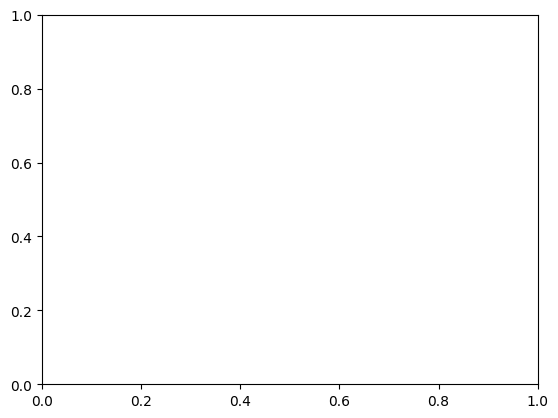

In [66]:
# proceed with implementing elbow method to find the best cluster number for azdias dataset
# kmeans.inertia_ is sum of squared distances of samples to their closest cluster center. We are looking 
# for the place where this number would not change drastically by increasing the number of clusters (elbow).
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(azdias_reduced.iloc[:,1:].values)
    wcss.append(kmeans.inertia_)

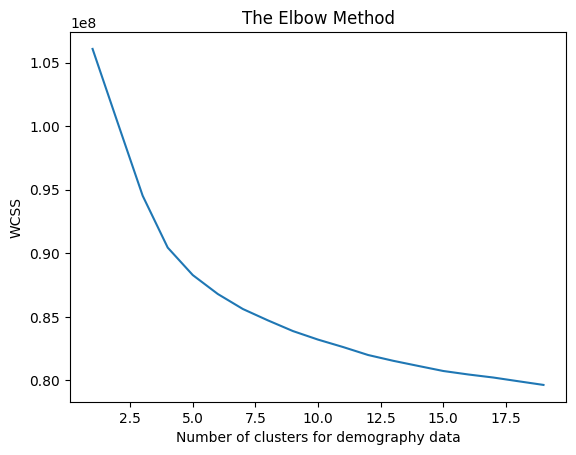

In [67]:
# plot the result
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters for demography data')
plt.ylabel('WCSS')
plt.show()

In [88]:
# based on the plot, we see that n_clusters=10 would be a good choice for clustering as inertia 
# is not meaningfully changing after this number. We thus go forward to cluster azdias dataset with
# n_clusters=10 and consider 1 cluster for customer dataset

# azdias clustering
kmeans1 = KMeans(n_clusters = 10, init = 'k-means++')
azdias_kmeans = kmeans1.fit_predict(azdias_reduced.iloc[:,1:])

# customers clustering
kmeans2 = KMeans(n_clusters = 1, init = 'k-means++')
customer_kmeans = kmeans2.fit_predict(customer_reduced.iloc[:,1:])


/home/Universe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/Universe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [89]:
from sklearn.metrics import pairwise_distances

# calculate cluster similarity by calculating Euclidean pairwise distance between clusters in two datasets
centroid_distances = pairwise_distances(kmeans1.cluster_centers_, kmeans2.cluster_centers_)
# convert Euclidean distances to similarities (using inverse distance)
similarity_matrix = 1 / (1 + centroid_distances)  


In [91]:
similarity_matrix
# we choose clusters 3 and 8 of the demography as the most similar clusters to the company customers

array([[0.02488811],
       [0.08678226],
       [0.10243211],
       [0.1591847 ],
       [0.1184324 ],
       [0.10843472],
       [0.134481  ],
       [0.09939991],
       [0.15072899],
       [0.09954378]])

In [92]:
# it means that clusters 3 and 8 from azdias are most similar to customers of the company

# assigning cluster labels to each dataset
azdias = azdias_reduced.copy()
customer = customer_reduced.copy()
azdias['Cluster_label']=kmeans1.labels_
customer['Cluster_label']=kmeans2.labels_

In [93]:
# we have now two datasets that are clustered and each cluster from azdias is mapped to the cluster in customer
# we make a dictionary including all individuals that are most likely similar to company customers

affine_individuals = {'Similar Individuals':[]}
for i in (3,8):
    affine_individuals['Similar Individuals'].extend(azdias.loc[azdias['Cluster_label']==i,'LNR'].values)
    

In [106]:
print('The number of individuals in the demography data that \
     \ncan represent customers in the company are {}'.format(len(affine_individuals['Similar Individuals'])))

The number of individuals in the demography data that      
can represent customers in the company are 67615


In [107]:
# save dictionary using pickling
import pickle

with open('affinity.pickle', 'wb') as file:
    pickle.dump(affine_individuals, file)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [108]:
mailout_train = pd.read_csv('./Data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('./Data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/tmp/ipykernel_5327/126734790.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('./Data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
/tmp/ipykernel_5327/126734790.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('./Data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [109]:
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,1.0,1.0,4.0,8.0,7.0,1,0,1,4
42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,1.0,1.0,1.0,5.0,9.0,7.0,1,0,1,3
42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,2.0,...,1.0,2.0,1.0,2.0,9.0,7.0,1,0,1,4
42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,3.0,...,2.0,3.0,4.0,2.0,9.0,2.0,3,0,2,4
